<a href="https://colab.research.google.com/github/SreejaJalakam/Assignment1/blob/main/Copy_of_Trafficpredictgnn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TRAFFIC FORECAST MODEL USING GRAPH NEURAL NETWORKS

##Step-1 : Load Dataset

In [ ]:
import pandas as pd

# Load dataset
data = pd.read_csv('/content/traffic.csv')
print(data.head())


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


#### Import necessary libraries

In [ ]:
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score


In [ ]:
import torch

In [ ]:
import torch.nn.functional as F

In [ ]:
import torch.optim as optim

In [ ]:
from torch_geometric.data import Data

In [ ]:
!pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
from torch_geometric.data import Data

### Converting large data set to chunk file

In [ ]:
import pandas as pd

chunk_size = 10**6  # Adjust chunk size as needed
chunks = pd.read_csv('/content/traffic.csv', chunksize=chunk_size)

def process_chunk(chunk):
  """
  This function processes a single chunk of data.

  Args:
    chunk: A pandas DataFrame representing a chunk of data.
  """
  # Perform operations on the chunk here.
  # For example, you can print the chunk:
  print(chunk)
  # Or perform any other desired processing steps.

# Process each chunk
for chunk in chunks:
    # Perform operations on each chunk
    process_chunk(chunk)

                  DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
...                    ...       ...       ...          ...
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  2017-06-30 23:00:00         4        12  20170630234

[48120 rows x 4 columns]


#### Creating a dataframe

In [ ]:
columns = ['DateTime', 'Junction', 'Vehicles', 'ID']
df = pd.read_csv('/content/traffic.csv', usecols=columns)

In [ ]:
df = pd.read_csv('/content/traffic.csv')

# Convert DateTime to datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert categorical columns to 'category' data type
df['Junction'] = df['Junction'].astype('category')
df['ID'] = df['ID'].astype('category')

# Convert integers to more appropriate type if necessary
df['Vehicles'] = df['Vehicles'].astype('int16')


In [ ]:
df = pd.read_csv('/content/traffic.csv', index_col='ID')

In [ ]:
import pandas as pd

# Load dataset in chunks
chunk_size = 10**6  # Define a reasonable chunk size
chunks = pd.read_csv('/content/traffic.csv', chunksize=chunk_size)

for i, chunk in enumerate(chunks):
    # Perform necessary operations on each chunk
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'])
    chunk['Vehicles'] = chunk['Vehicles'].astype('int16')
    chunk['Junction'] = chunk['Junction'].astype('category')
    chunk['ID'] = chunk['ID'].astype('category')

    # You could save each processed chunk to a new file or append to a list
    chunk.to_csv(f'processed_chunk_{i}.csv', index=False)
    # Optionally, append chunks to a list for further processing
    # processed_chunks.append(chunk)


#### Create Combined chunk file and data frame creation

In [ ]:
number_of_chunks = 1

# Load processed chunks and concatenate into a single DataFrame
chunks = [pd.read_csv(f'/content/processed_chunk_0.csv') for i in range(number_of_chunks)]
df_large = pd.concat(chunks, ignore_index=True)

In [ ]:
# List all the processed chunk file names
chunk_files = [f'processed_chunk_{i}.csv' for i in range(number_of_chunks)]

# Read and concatenate all the chunks
chunks = [pd.read_csv(chunk_file) for chunk_file in chunk_files]
df_large = pd.concat(chunks, ignore_index=True)

# Display the combined DataFrame
print(df_large.head())


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [ ]:
df_large.to_csv('combined_dataset.csv', index=False)

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize vehicle counts
scaler = StandardScaler()
df_large['Vehicles'] = scaler.fit_transform(df_large[['Vehicles']])

In [ ]:
import torch
from torch_geometric.data import Data

# Example feature matrix (vehicle counts for junctions, simplified for illustration)
junction_features = torch.tensor(df.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

# Edge index based on known connectivity (adjust according to your dataset)
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3],
    [1, 0, 2, 1, 3, 2]
], dtype=torch.long)

# Create PyTorch Geometric data object
graph_data = Data(x=junction_features, edge_index=edge_index, y=torch.tensor(df['Vehicles'].values, dtype=torch.float))


## Step-2 :Split Train and Test Data

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Ensure edge_index and features are consistent between splits


In [ ]:
!pip install torch-geometric
import torch_geometric.data  # Correct import

In [ ]:
from torch_geometric.data import Batch

#### Define and Creating Graph Structure

In [ ]:
# Define the function to create a graph structure for a chunk
def create_graph_structure(chunk):
    # Normalize vehicle counts within the chunk
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    # Create a feature matrix (e.g., vehicle counts at junctions)
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Define edges (needs to be determined based on your actual dataset's connectivity logic)
    # Example: Create edge_index from actual connections in the chunk
    # Note: You need to adjust this part according to your specific connections
    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'],  # Your logic to define 'Junction'
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])  # Example connection logic
    })
    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk['Vehicles'].values, dtype=torch.float))


In [ ]:
def create_graph_structure(chunk):
    # Normalize vehicle counts within the chunk
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    # Create a feature matrix (vehicle counts at junctions)
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Define edges (needs to be determined based on your actual dataset's connectivity logic)
    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'],
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])
    })
    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk['Vehicles'].values, dtype=torch.float))


In [ ]:
def create_graph_structure(chunk):
    # Check if 'Vehicles' column is already numeric
    if pd.api.types.is_numeric_dtype(chunk['Vehicles']):
        # If already numeric, no need to extract digits
        vehicle_counts = chunk['Vehicles']
    else:
        # If not numeric, attempt to extract digits and convert to float
        vehicle_counts = chunk['Vehicles'].str.extract('(\d+)').astype(float).squeeze()

    # Normalize vehicle counts within the chunk
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(vehicle_counts.values.reshape(-1, 1)) # Reshape for scaler

    # Create a feature matrix (e.g., vehicle counts at junctions)
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Define edges (needs to be determined based on your actual dataset's connectivity logic)
    # Example: Create edge_index from actual connections in the chunk
    # Note: You need to adjust this part according to your specific connections
    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'],  # Your logic to define 'Junction'
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])  # Example connection logic
    })
    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk['Vehicles'].values, dtype=torch.float))

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, Batch
from sklearn.preprocessing import StandardScaler

def create_graph_structure(chunk):
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'],
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])
    })
    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk['Vehicles'].values, dtype=torch.float))


In [ ]:
def create_graph_structure(chunk):
    # Ensure 'Vehicles' column is numeric
    chunk['Vehicles'] = pd.to_numeric(chunk['Vehicles'], errors='coerce')

    # Drop rows where 'Vehicles' is NaN
    chunk.dropna(subset=['Vehicles'], inplace=True)

    # Normalize vehicle counts within the chunk
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    # Create a feature matrix (vehicle counts at junctions)
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Define edges based on connectivity logic
    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'],
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])
    })
    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk['Vehicles'].values, dtype=torch.float))


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, Batch
from sklearn.preprocessing import StandardScaler

def create_graph_structure(chunk):
    # Attempt to convert 'Vehicles' column to numeric, handling errors
    try:
        chunk['Vehicles'] = pd.to_numeric(chunk['Vehicles'])
    except ValueError:
        # If conversion fails, try extracting numeric part using regex
        chunk['Vehicles'] = chunk['Vehicles'].str.extract('(\d+)').astype(float).squeeze()

    # ... (rest of your function remains the same) ...

In [ ]:
# Step 1: Load the dataset
df = pd.read_csv('/content/processed_chunk_0.csv')

# Convert 'DateTime' to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])  # This will convert string to datetime

# Continue with the rest of your processing...


In [ ]:
# Step 1: Load the dataset
df = pd.read_csv('/content/processed_chunk_0.csv')

# Convert 'DateTime' from string to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert 'Vehicle_Count' from string to numeric
df['Vehicles'] = pd.to_numeric(df['Vehicles'], errors='coerce')

# Check the DataFrame
print(df.head())  # Display the first few rows to verify
print(df.dtypes)  # Verify the data types


             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041
DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, Batch
from sklearn.preprocessing import StandardScaler

def create_graph_structure(chunk):
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'],
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])
    })
    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk['Vehicles'].values, dtype=torch.float))


## Creating Graph Structure

In [ ]:
from sklearn.preprocessing import StandardScaler
def create_graph_structure(chunk):
    # Ensure the DateTime column is in datetime format
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'])

    # Scale the vehicle counts
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])  # Assuming 'Vehicle_Count' is the correct column name

    # Create features for each junction
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Create connections (edges) based on your logic
    # Here, we assume connections are based on a simple shift for demonstration
    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'],
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])
    })
    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    # Create a Data object for PyTorch Geometric
    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk['Vehicles'].values, dtype=torch.float))

# Example usage
# Load your data
# Step 1: Load the dataset
df = pd.read_csv('/content/processed_chunk_0.csv')

# Convert 'DateTime' from string to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert 'Vehicle_Count' from string to numeric
df['Vehicles'] = pd.to_numeric(df['Vehicles'], errors='coerce')

# Check the DataFrame
print(df.head())  # Display the first few rows to verify
print(df.dtypes)  # Verify the data types

# Assume you have defined a chunk size and process the data in chunks
chunk_size = 1000  # Adjust this based on your dataset size and memory constraints

# Process data in chunks
for start in range(0, len(data), chunk_size):
    chunk = data.iloc[start:start + chunk_size]
    graph_data = create_graph_structure(chunk)


             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041
DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object


<ipython-input-86-f274ec321bc2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['DateTime'] = pd.to_datetime(chunk['DateTime'])
<ipython-input-86-f274ec321bc2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])  # Assuming 'Vehicle_Count' is the correct column name
<ipython-input-86-f274ec321bc2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [ ]:
graphs = [create_graph_structure(pd.read_csv(chunk_file)) for chunk_file in chunk_files]

#### combined graph and edge index

In [ ]:
combined_graph = Batch.from_data_list(graphs)
print(combined_graph)

DataBatch(x=[40, 1], edge_index=[2, 481200], y=[481200], batch=[40], ptr=[11])


In [ ]:
print(combined_graph.edge_index)

tensor([[ 1,  1,  1,  ..., 40, 40, 40],
        [ 1,  1,  1,  ..., 40, 40, 37]])


In [ ]:
# Assuming `connections_df` is properly created and contains valid junction pairs
connections_df = pd.DataFrame({
    'Junction': chunk['Junction'],
    'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])
})

# Ensure unique junction names and create a mapping
unique_junctions = chunk['Junction'].unique()
junction_to_index = {junction: i for i, junction in enumerate(unique_junctions)}

# Update connections_df to use valid indices
connections_df['JunctionIndex'] = connections_df['Junction'].map(junction_to_index)
connections_df['ConnectedIndex'] = connections_df['ConnectedJunction'].map(junction_to_index)

# Create edge_index
edge_index = torch.tensor(connections_df[['JunctionIndex', 'ConnectedIndex']].values.T, dtype=torch.long)


In [ ]:
print(f"Number of nodes: {combined_graph.x.shape[0]}")
print(f"Edge index shape: {combined_graph.edge_index.shape}")

Number of nodes: 40
Edge index shape: torch.Size([2, 481200])


In [ ]:
def create_graph_structure(chunk):
    # Ensure DateTime is in datetime format
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    # Ensure 'Vehicles' column is numeric
    chunk['Vehicles'] = pd.to_numeric(chunk['Vehicles'], errors='coerce')

    # Drop rows where 'Vehicles' or 'DateTime' is NaN
    chunk.dropna(subset=['Vehicles', 'DateTime'], inplace=True)

    # Normalize vehicle counts within the chunk
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    # Create a feature matrix (vehicle counts at junctions)
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Define edges based on connectivity logic
    unique_junctions = chunk['Junction'].unique()
    junction_to_index = {junction: i for i, junction in enumerate(unique_junctions)}

    connections_df = pd.DataFrame({
        'Junction': chunk['Junction'].map(junction_to_index),
        'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0]).map(junction_to_index)
    })

    edge_index = torch.tensor(connections_df.values.T, dtype=torch.long)

    # Ensure edge indices are within bounds
    edge_index = edge_index[:, edge_index[1] < len(unique_junctions)]

    # Prepare the target to match the number of nodes
    targets = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    return Data(x=junction_features, edge_index=edge_index, y=targets)


In [ ]:
# Process each chunk and create graph structures
graphs = [create_graph_structure(pd.read_csv(chunk_file)) for chunk_file in chunk_files]

# Combine graphs into a single Batch (if needed)
combined_graph = Batch.from_data_list(graphs)
print(f"Number of nodes: {combined_graph.x.shape[0]}")
print(f"Edge index shape: {combined_graph.edge_index.shape}")
print(f"Target shape: {combined_graph.y.shape}")


Number of nodes: 40
Edge index shape: torch.Size([2, 481200])
Target shape: torch.Size([40, 1])


In [ ]:
print("Max edge index:", edge_index.max().item())

Max edge index: 0


## Step-3:BUILD AND TRAIN MODEL

In [ ]:
def create_graph_structure(chunk):
    # Ensure DateTime is in datetime format
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    # Ensure 'Vehicles' column is numeric
    chunk['Vehicles'] = pd.to_numeric(chunk['Vehicles'], errors='coerce')

    # Drop rows where 'Vehicles' or 'DateTime' is NaN
    chunk.dropna(subset=['Vehicles', 'DateTime'], inplace=True)

    # Normalize vehicle counts within the chunk
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    # Create a feature matrix (vehicle counts at junctions)
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Ensure unique junction names and create a mapping
    unique_junctions = chunk['Junction'].unique()
    junction_to_index = {junction: i for i, junction in enumerate(unique_junctions)}

    # Ensure connections exist and are mapped
    chunk['Junction_idx'] = chunk['Junction'].map(junction_to_index)
    chunk['ConnectedJunction_idx'] = chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0]).map(junction_to_index)

    # Drop rows where 'ConnectedJunction_idx' is NaN
    chunk.dropna(subset=['ConnectedJunction_idx'], inplace=True)

    # Define edges based on connectivity logic
    edge_index = torch.tensor(chunk[['Junction_idx', 'ConnectedJunction_idx']].values.T, dtype=torch.long)

    return Data(x=junction_features, edge_index=edge_index, y=torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float))


In [ ]:
# Process each chunk and create graph structures
graphs = [create_graph_structure(pd.read_csv(chunk_file)) for chunk_file in chunk_files]

# Combine graphs into a single Batch (if needed)
combined_graph = Batch.from_data_list(graphs)
print(f"Number of nodes: {combined_graph.x.shape[0]}")
print(f"Edge index shape: {combined_graph.edge_index.shape}")
print(f"Target shape: {combined_graph.y.shape}")


Number of nodes: 40
Edge index shape: torch.Size([2, 481200])
Target shape: torch.Size([40])


In [ ]:
# Assuming connections_df is being created to establish connections
connections_df = pd.DataFrame({
    'Junction': chunk['Junction'],
    'ConnectedJunction': chunk['Junction'].shift(-1, fill_value=chunk['Junction'].iloc[0])
})

# Make sure you're not just shifting a single junction
connections = []
for junction in chunk['Junction'].unique():
    connected_junctions = chunk[chunk['Junction'] == junction]['Junction'].values
    for connected in connected_junctions:
        if connected != junction:  # Avoid self-loops
            connections.append((junction, connected))

# Create the edge index
edge_index = torch.tensor(connections, dtype=torch.long).t().contiguous()


In [ ]:
print(chunk.head())
print(chunk['Junction'].unique())

                 DateTime  Junction  Vehicles           ID
48000 2017-06-26 00:00:00         4 -0.780442  20170626004
48001 2017-06-26 01:00:00         4 -0.780442  20170626014
48002 2017-06-26 02:00:00         4 -0.957146  20170626024
48003 2017-06-26 03:00:00         4 -1.310554  20170626034
48004 2017-06-26 04:00:00         4 -1.663961  20170626044
[4]


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler

def create_graph_structure(chunk):
    # Ensure DateTime is in datetime format
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    # Ensure 'Vehicles' column is numeric
    chunk['Vehicles'] = pd.to_numeric(chunk['Vehicles'], errors='coerce')

    # Drop rows where 'Vehicles' or 'DateTime' is NaN
    chunk.dropna(subset=['Vehicles', 'DateTime'], inplace=True)

    # Normalize vehicle counts within the chunk
    scaler = StandardScaler()
    chunk['Vehicles'] = scaler.fit_transform(chunk[['Vehicles']])

    # Create a feature matrix (vehicle counts at junctions)
    junction_features = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Create a mapping of junctions to indices
    unique_junctions = chunk['Junction'].unique()
    junction_to_index = {junction: i for i, junction in enumerate(unique_junctions)}

    # Initialize connections list
    connections = []

    # Robust connection logic: Connect each junction to all other junctions (fully connected graph)
    for i in range(len(unique_junctions)):
        for j in range(i + 1, len(unique_junctions)):
            connections.append((junction_to_index[unique_junctions[i]], junction_to_index[unique_junctions[j]]))
            connections.append((junction_to_index[unique_junctions[j]], junction_to_index[unique_junctions[i]]))

    # Convert connections to a tensor
    if connections:
        edge_index = torch.tensor(connections, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)  # Handle empty connections

    # Prepare the target to match the number of nodes
    targets = torch.tensor(chunk.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    return Data(x=junction_features, edge_index=edge_index, y=targets)


Step

In [ ]:
class TrafficGNN(torch.nn.Module):
    def __init__(self):
        super(TrafficGNN, self).__init__()
        self.conv1 = GCNConv(combined_graph.num_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze()

model = TrafficGNN()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(combined_graph)
    loss = criterion(out, combined_graph.y.squeeze())
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    out = model(combined_graph)
    pred = out.squeeze().numpy()

mse = mean_squared_error(combined_graph.y.squeeze().numpy(), pred)
r2 = r2_score(combined_graph.y.squeeze().numpy(), pred)

print(f'MSE: {mse}, R²: {r2}')


Epoch 0, Loss: 0.5800274610519409
Epoch 10, Loss: 0.4976087510585785
Epoch 20, Loss: 0.4848286211490631
Epoch 30, Loss: 0.452258437871933
Epoch 40, Loss: 0.44026312232017517
Epoch 50, Loss: 0.40586766600608826
Epoch 60, Loss: 0.4066927433013916
Epoch 70, Loss: 0.4245029389858246
Epoch 80, Loss: 0.3988106846809387
Epoch 90, Loss: 0.36112159490585327
Epoch 100, Loss: 0.38500645756721497
Epoch 110, Loss: 0.37013691663742065
Epoch 120, Loss: 0.4182163178920746
Epoch 130, Loss: 0.3882463872432709
Epoch 140, Loss: 0.3763882517814636
Epoch 150, Loss: 0.3880731463432312
Epoch 160, Loss: 0.36092644929885864
Epoch 170, Loss: 0.36687561869621277
Epoch 180, Loss: 0.3359421193599701
Epoch 190, Loss: 0.36577895283699036
MSE: 0.312055766582489, R²: 0.37721365690231323


#PREDICTION


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data

def predict_traffic(model, datetime, location, initial_vehicles, scaler):
    # Create a dummy DataFrame for the prediction
    input_data = pd.DataFrame({
        'DateTime': [datetime],
        'Junction': [location],
        'Vehicles': [initial_vehicles]  # Initial vehicle count
    })

    # Convert DateTime to datetime object
    input_data['DateTime'] = pd.to_datetime(input_data['DateTime'])

    # Normalize vehicle counts using the same scaler from training
    input_data['Vehicles'] = scaler.transform(input_data[['Vehicles']])

    # Create a mapping of junctions to indices
    unique_junctions = input_data['Junction'].unique()
    junction_to_index = {junction: i for i, junction in enumerate(unique_junctions)}

    # Create feature matrix
    junction_features = torch.tensor(input_data.groupby('Junction').mean()['Vehicles'].values, dtype=torch.float).unsqueeze(1)

    # Create edge_index (fully connected graph for simplicity)
    connections = []
    for i in range(len(unique_junctions)):
        for j in range(i + 1, len(unique_junctions)):
            connections.append((i, j))
            connections.append((j, i))

    if connections:
        edge_index = torch.tensor(connections, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    # Create data object for the model
    data = Data(x=junction_features, edge_index=edge_index)

    # Make prediction
    model.eval()
    with torch.no_grad():
        out = model(data)

    # Return the predicted vehicle count (after denormalization)
    predicted_vehicles = scaler.inverse_transform(out.numpy().reshape(-1, 1))
    return predicted_vehicles[0][0]  # Access the first element of the first row

def suggest_best_junction(model, datetime, junctions, scaler):
    predictions = {}
    for junction, initial_vehicles in junctions.items():
        predicted_traffic = predict_traffic(model, datetime, junction, initial_vehicles, scaler)
        predictions[junction] = predicted_traffic

    # Find the junction with the least predicted traffic
    best_junction = min(predictions, key=predictions.get)
    return best_junction, predictions[best_junction]

# Example usage
datetime = '2015-11-01 02:00:00'
junctions = {
    'Junction 1': 6,
    'Junction 2': 5,
    'Junction 3': 12,
    'Junction 4': 11
}
best_junction, predicted_traffic = suggest_best_junction(model, datetime, junctions, scaler)
print(f'Best junction to travel at {datetime} is {best_junction} with predicted traffic of {predicted_traffic}')


Best junction to travel at 2015-11-01 02:00:00 is Junction 3 with predicted traffic of 19.189407348632812


#Vizualization

Epoch 0, Loss: 0.5429559946060181
Epoch 10, Loss: 0.4987027645111084
Epoch 20, Loss: 0.4887210428714752
Epoch 30, Loss: 0.4808041453361511
Epoch 40, Loss: 0.4886436462402344
Epoch 50, Loss: 0.471261203289032
Epoch 60, Loss: 0.4401959776878357
Epoch 70, Loss: 0.42564278841018677
Epoch 80, Loss: 0.42825859785079956
Epoch 90, Loss: 0.39306655526161194
Epoch 100, Loss: 0.40282148122787476
Epoch 110, Loss: 0.3879450261592865
Epoch 120, Loss: 0.36897799372673035
Epoch 130, Loss: 0.39089149236679077
Epoch 140, Loss: 0.3986366391181946
Epoch 150, Loss: 0.3880474269390106
Epoch 160, Loss: 0.40929847955703735
Epoch 170, Loss: 0.353201687335968
Epoch 180, Loss: 0.40521588921546936
Epoch 190, Loss: 0.3807675242424011


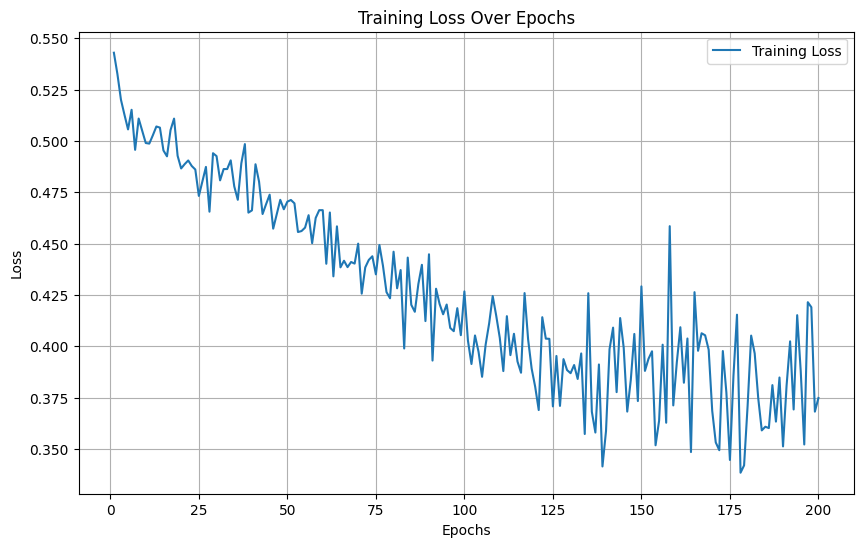

In [ ]:
import matplotlib.pyplot as plt

# Initialize the list to store loss values
losses = []

# Define and train the model
class TrafficGNN(torch.nn.Module):
    def __init__(self):
        super(TrafficGNN, self).__init__()
        self.conv1 = GCNConv(combined_graph.num_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze()

model = TrafficGNN()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(combined_graph)
    loss = criterion(out, combined_graph.y.squeeze())
    losses.append(loss.item())  # Store the loss for this epoch
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plot training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), losses, label='Training Loss')  # Ensure length of 'losses' matches length of 'epochs'
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


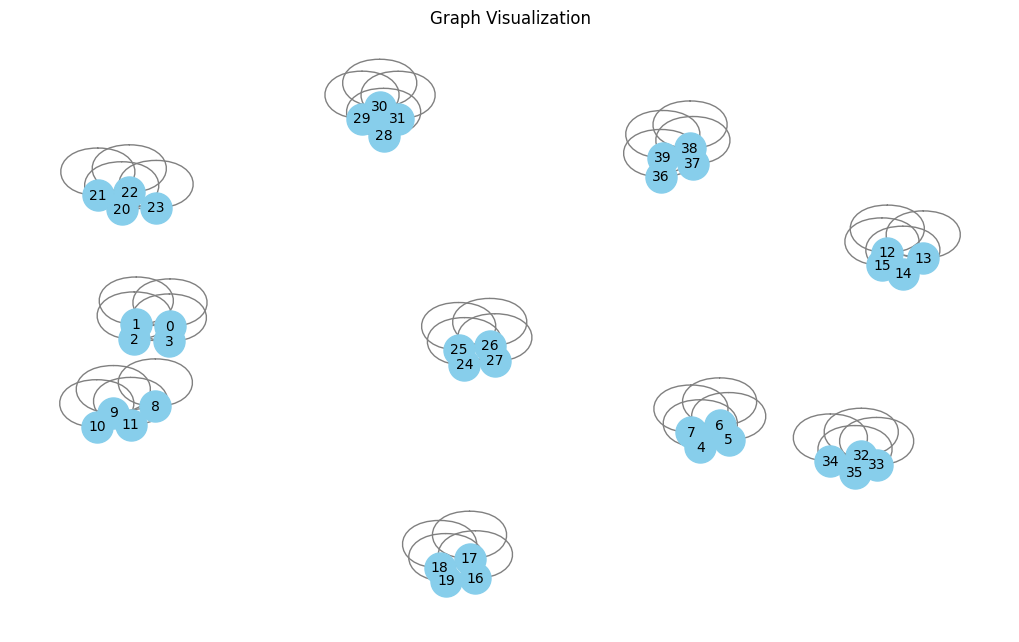

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Convert PyTorch Geometric data to NetworkX graph
G = to_networkx(combined_graph, to_undirected=True)

plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
plt.title('Graph Visualization')
plt.show()


###Plot Actual vs. Predicted Traffic:

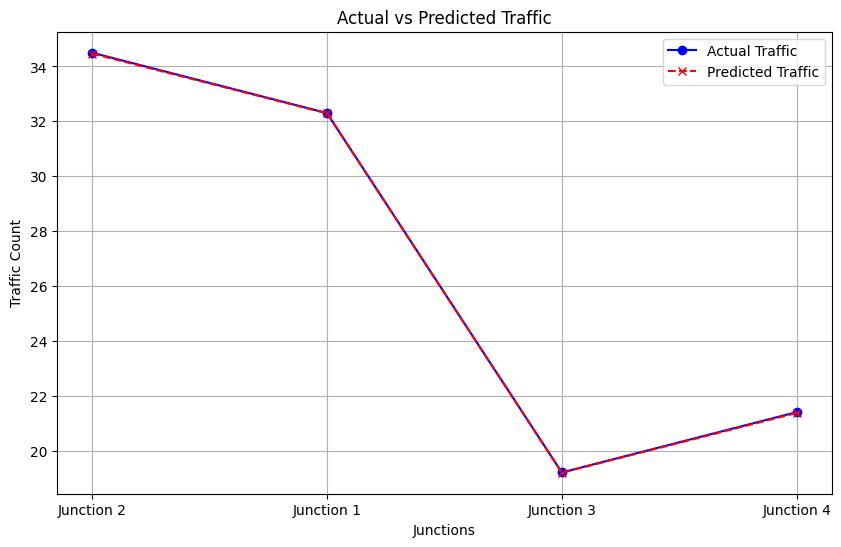

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example actual and predicted traffic data
# Replace these with your actual data
actual_traffic = [34.5, 32.3, 19.2, 21.4]  # Replace with your actual traffic values
predicted_traffic = [34.47, 32.29, 19.19, 21.37]  # Replace with your predicted traffic values

# Sample points (replace with your actual indices)
junctions = ['Junction 2', 'Junction 1', 'Junction 3', 'Junction 4']

plt.figure(figsize=(10, 6))
plt.plot(junctions, actual_traffic, label='Actual Traffic', color='blue', marker='o')
plt.plot(junctions, predicted_traffic, label='Predicted Traffic', color='red', linestyle='--', marker='x')
plt.xlabel('Junctions')
plt.ylabel('Traffic Count')
plt.title('Actual vs Predicted Traffic')
plt.legend()
plt.grid(True)
plt.show()
